In [9]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
from PIL import Image
folder_path = '/home/bjangley/VPR/VPRMethods/final_mast3r_test_dataset'
metadata_file = '/home/bjangley/VPR/VPRMethods/final_mast3r_test_dataset/metadata.csv'

In [10]:
set1 = np.arange(0,9)
set2 = np.arange(9,18)
set3 = np.arange(18,27)
set4 = np.arange(27,36)
set5 = np.arange(36,45)
scene_locations = [[0,0], 
                [200,0],
                [200,200],
                [200,-200],
                [0,200],
                [0,-200],
                [-200,0],
                [-200,200],
                [-200,-200]
                ]

scene_locations2 = [[0,0], 
                [0,-200],
                [0,200],
                [200,0],
                [-200,0],
                [200,-200],
                [-200,-200],
                [200,200],
                [-200,200]

                ]


scene_locations3 = [[0,0], 
                [200,0],
                [-200,0],
                [0,200],
                [0,-200],
                [200,200],
                [200,-200],
                [-200,200],
                [-200,-200]

                ]

scene_locations4 = [[0,0], 
                [-200,0],
                [200,0],
                [0,-200],
                [0,200],
                [-200,-200],
                [-200,200],
                [200,-200],
                [200,200]

                ]

scene_locations5 = [[0,200], 
                [200,200],
                [-200,200],
                [0,400],
                [0,0],
                [200,400],
                [0,200],
                [-200,400],
                [-200,0]
                ]


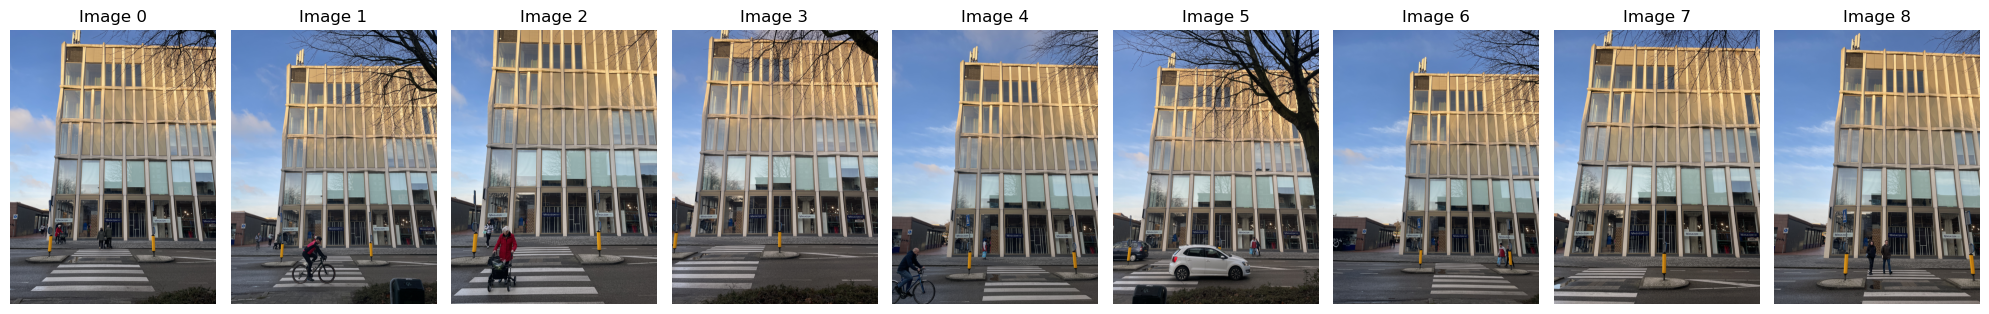

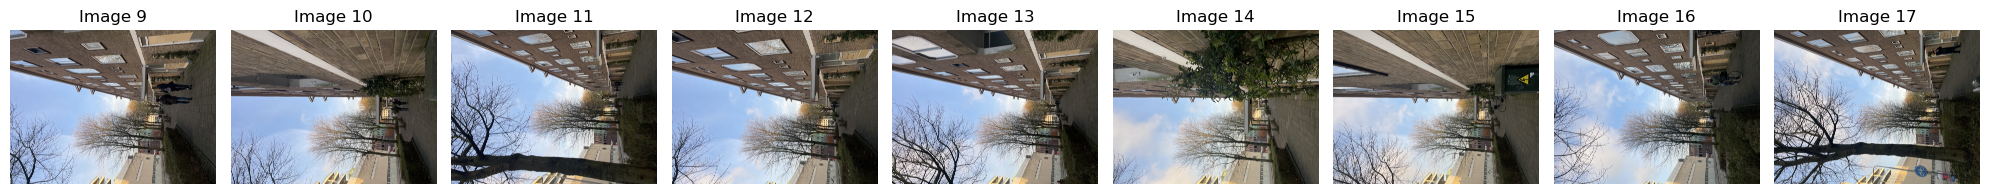

In [11]:
def getImageFromIndex(index, image_folder):
    filename = image_folder + '/metadata.csv'
    with open(filename, 'r', newline='') as csvfile:
        csvreader = csv.DictReader(csvfile)
        
        for row in csvreader:
            if row['id'] == str(index):
                image_path = os.path.join(image_folder, row['image_name'])
                return row, image_path
        
        return None  # ID not found
    

def plotImages(image_indices,image_folder, rotate=False, title=None):
    # Get image paths
    image_paths = [getImageFromIndex(index, image_folder)[1] for index in image_indices]
    
    # Open images
    images = [Image.open(path) for path in image_paths]
    
    # Create figure
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    if len(images) == 1:
        axes = [axes]
    
    # Plot images
    for ax, img, index in zip(axes, images, image_indices):
        if rotate:
            img = img.rotate(-90, expand=True)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Image {index}')
    
    # Set main title if provided
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

plotImages(set1, folder_path, rotate=True)
plotImages(set2, folder_path)

In [12]:
# known_image_path = '/home/bjangley/VPR/mast3r/utrecht/IMG_1539_converted.png'
# unknown_image_path = '/home/bjangley/VPR/mast3r/utrecht/799338198457726_converted.png'
known_image_size = [4032, 3024]
master_size = [512,384]
"""Getting mast3r output"""


from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs
import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

#imports for visualizing matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2 #for pnp
from pyproj import Proj, transform #cartographic transformations and coordinate conversions

#supressing unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import time

# start_time = time.time()
# # Your code block here
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time:.4f} seconds")

#ensuring i dont exceed cpu limits?
import os
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

device = 'cuda:7'
schedule = 'cosine'
lr = 0.01
niter = 300
boarder = 3


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))



def getMasterOutout(known_image, unknown_image,threshold,visualizeMatches=False): 
    #inputs known image and unknown image paths to return mast3r output

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    ##load model and run inference
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    images = load_images([known_image, unknown_image], size=512)
    print("Images shape: ",images[0]['true_shape'])
    mast3r_inference_start = time.time()
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)
    mast3r_inference_stop = time.time()
    mast3r_inference_time = mast3r_inference_stop-mast3r_inference_start
    print(f"Mast3r Inference Time: {mast3r_inference_time:.4f} seconds.")
    # at this stage, you have the raw dust3r predictions 
    #dust3r predictions are the original two heads outputing 3d point cloud and confidence
    #master adds another that includes an additional head for local features


    view1 = output['view1'] #some form of the image to size of the point cloud -- used to get the size of the matches 
    view2 = output['view2'] 

    pred1 = output['pred1'] #3d point cloud 
    pred2 = output['pred2']

    desc1 = pred1['desc'].squeeze(0).detach() #local features
    desc2 = pred2['desc'].squeeze(0).detach()



    # find 2D-2D matches between the two images
    #feature based mapping to recover point correspdances/matches
    point_matches_start=time.time()
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                    device=device, dist='dot', block_size=2**13)
    point_matches_stop = time.time()
    point_matches_time = point_matches_stop-point_matches_start
    print(f"Point Matches Time: {point_matches_time:.4f} seconds.")
    

    ignore = 0 #to ignore correspondances in the lower half of the image
    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= boarder) & (matches_im0[:, 0] < int(W0) - boarder) & (
        matches_im0[:, 1] >= boarder) & (matches_im0[:, 1] < int(H0) - boarder -ignore)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= boarder) & (matches_im1[:, 0] < int(W1) - boarder) & (
        matches_im1[:, 1] >= boarder) & (matches_im1[:, 1] < int(H1) - boarder -ignore)

    valid_matches = valid_matches_im0 & valid_matches_im1

    # matches are Nx2 image coordinates.
    matches_im0 = matches_im0[valid_matches]
    matches_im1 = matches_im1[valid_matches]

    # Convert the other outputs to numpy arrays
    #point correspondances with respect to the coordinate system of the first image 
    pts3d_im0 = pred1['pts3d'].squeeze(0).detach().cpu().numpy() 
    pts3d_im1 = pred2['pts3d_in_other_view'].squeeze(0).detach().cpu().numpy() 

    conf_im0 = pred1['conf'].squeeze(0).detach().cpu().numpy() #confidence 
    conf_im1 = pred2['conf'].squeeze(0).detach().cpu().numpy()

    desc_conf_im0 = pred1['desc_conf'].squeeze(0).detach().cpu().numpy()
    desc_conf_im1 = pred2['desc_conf'].squeeze(0).detach().cpu().numpy()
    

    # Extract confidence scores for the matches
    match_conf_im0 = conf_im0[matches_im0[:, 1], matches_im0[:, 0]]
    match_conf_im1 = conf_im1[matches_im1[:, 1], matches_im1[:, 0]]

    normalized_conf_im0 = min_max_normalize(conf_im0)
    normalized_conf_im1 = min_max_normalize(conf_im1)

    #print("Normalization: ", np.max(normalized_conf_im0), np.min(normalized_conf_im0))




    if visualizeMatches:

        # Histogram for confidence scores of matches
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Histogram for Image 0 matches
        ax1.hist(match_conf_im0, bins=50, edgecolor='black', color='skyblue')
        ax1.set_title('Histogram of Confidence Scores (Image 0 Matches)')
        ax1.set_xlabel('Confidence Value')
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)

        # Histogram for Image 1 matches
        ax2.hist(match_conf_im1, bins=50, edgecolor='black', color='lightgreen')
        ax2.set_title('Histogram of Confidence Scores (Image 1 Matches)')
        ax2.set_xlabel('Confidence Value')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # visualize a few matches
        n_viz = 20
        num_matches = matches_im0.shape[0]
        print("Number of matches: ",num_matches)
        match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
        viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

        image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
        image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

        viz_imgs = []
        for i, view in enumerate([view1, view2]):
            rgb_tensor = view['img'] * image_std + image_mean
            viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

        H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
        img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
        img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
        img = np.concatenate((img0, img1), axis=1)
        pl.figure()
        pl.imshow(img)
        cmap = pl.get_cmap('jet')
        for i in range(n_viz):
            (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
            pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
        pl.show(block=True)

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot the image
        im = ax.imshow(img)
        ax.set_title('Image Matches with Confidence')

        # Create scatter plots of matches with color-coded confidence
        scatter_im0 = ax.scatter(matches_im0[:, 0], matches_im0[:, 1], 
                                c=normalized_conf_im0[matches_im0[:, 1], matches_im0[:, 0]], 
                                cmap='viridis', s=10, alpha=0.7)
        scatter_im1 = ax.scatter(matches_im1[:, 0] + W0, matches_im1[:, 1], 
                                c=normalized_conf_im1[matches_im1[:, 1], matches_im1[:, 0]], 
                                cmap='viridis', s=10, alpha=0.7)

        # Create a divider for the existing axes instance
        divider = make_axes_locatable(ax)

        # Add an axes to the right of the main axes
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # Create colorbar with the same height as the image
        plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1), cmap='viridis'), 
             cax=cax, label='Normalized Confidence')

        plt.tight_layout()
        plt.show()


    conf_mask = (conf_im0[matches_im0[:, 1], matches_im0[:, 0]] > threshold) & \
                (conf_im1[matches_im1[:, 1], matches_im1[:, 0]] > threshold)

    # Apply the mask to filter matches and other data
    matches_im0 = matches_im0[conf_mask] #query
    matches_im1 = matches_im1[conf_mask] #map


        # def get_second_most_frequent(conf):
    #     unique, counts = np.unique(conf, return_counts=True)
    #     sorted_indices = np.argsort(-counts)
    #     return unique[sorted_indices[1]] if len(unique) > 1 else unique[0]
    
    # # Get thresholds for each image
    # threshold_im0 = get_second_most_frequent(match_conf_im0)
    # threshold_im1 = get_second_most_frequent(match_conf_im1)

    # print("Threshold (anchor and query): ", threshold_im0, threshold_im1)

    # # Apply thresholds to filter matches
    # conf_mask_im0 = match_conf_im0 > threshold_im0
    # conf_mask_im1 = match_conf_im1 > threshold_im1
    # conf_mask = conf_mask_im0 & conf_mask_im1

    # # Apply the mask to filter matches
    # matches_im0 = matches_im0[conf_mask]
    # matches_im1 = matches_im1[conf_mask]
        

    # def get_second_highest_peak(data):
    #     hist, bin_edges = np.histogram(data, bins=50)
    #     sorted_indices = np.argsort(hist)
    #     second_highest_bin = sorted_indices[-2]
    #     return bin_edges[second_highest_bin]
    
    # threshold_im0 = get_second_highest_peak(conf_im0[matches_im0[:, 1], matches_im0[:, 0]])
    # threshold_im1 = get_second_highest_peak(conf_im1[matches_im1[:, 1], matches_im1[:, 0]])
    # print("Threshold (anchor and query): ", threshold_im0, threshold_im1)

    # conf_mask = (conf_im0[matches_im0[:, 1], matches_im0[:, 0]] >= threshold_im0) & \
    #         (conf_im1[matches_im1[:, 1], matches_im1[:, 0]] >= threshold_im1)

    # matches_im0 = matches_im0[conf_mask]
    # matches_im1 = matches_im1[conf_mask]
        
    # Sort matches by confidence scores
    # sorted_indices_im0 = np.argsort(match_conf_im0)[::-1]
    # sorted_indices_im1 = np.argsort(match_conf_im1)[::-1]

    # # Select top 200 matches or all matches if fewer than 200
    # top_matches_im0 = sorted_indices_im0[:min(300, len(sorted_indices_im0))]
    # top_matches_im1 = sorted_indices_im1[:min(300, len(sorted_indices_im1))]

    # # Create a mask for the union of top matches from both images
    # conf_mask = np.zeros(len(matches_im0), dtype=bool)
    # conf_mask[top_matches_im0] = True
    # conf_mask[top_matches_im1] = True

    # # Apply the mask to filter matches
    # matches_im0 = matches_im0[conf_mask]
    # matches_im1 = matches_im1[conf_mask]


    print("Number of matches after conf mask: ", matches_im0.shape[0])
    
    return matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1


def scale_intrinsics(K: np.ndarray, prev_w: float, prev_h: float, master_w: float, master_h: float) -> np.ndarray:
    """Scale the intrinsics matrix by a given factor .

    Args:
        K (NDArray): 3x3 intrinsics matrix
        scale (float): Scale factor

    Returns:
        NDArray: Scaled intrinsics matrix
    """
    #3024x4032 --> 384x512

    assert K.shape == (3, 3), f"Expected (3, 3), but got {K.shape=}"

    scale_w = master_w / prev_w  # sizes of the images in the Mast3r dataset
    scale_h = master_h / prev_h  # sizes of the images in the Mast3r dataset

    K_scaled = K.copy()
    K_scaled[0, 0] *= scale_w
    K_scaled[0, 2] *= scale_w
    K_scaled[1, 1] *= scale_h
    K_scaled[1, 2] *= scale_h

    return K_scaled

def CameraMatrix(fx,fy,cx,cy):
    return np.array([[fx,  0, cx],
                     [ 0, fy, cy],
                     [ 0,  0, 1]])

def run_pnp(pts2D, pts3D, K): 
    """
    intrinsics= K

    mode='cv2'
    """
    print(pts3D.shape,"shape")
    success, r_pose, t_pose, _ = cv2.solvePnPRansac(pts3D, pts2D, K, None, flags=cv2.SOLVEPNP_SQPNP,
                                                    iterationsCount=10_000,
                                                    reprojectionError=3,
                                                    confidence=0.9999) #returns 3d to 2d transfromation, known to unknown 
    if not success:
        print("Failed to find transform")
        return False, None
    r_pose = cv2.Rodrigues(r_pose)[0]  # world2cam == world2cam2
    RT = np.r_[np.c_[r_pose, t_pose], [(0,0,0,1)]] # world2cam2 #known to unknown

    return True, np.linalg.inv(RT)  # cam2toworld

def get_rotation_from_compass(compass_angle):
    """ Create a rotation matrix based on compass angle (in radians). """
    return np.array([
        [np.cos(compass_angle), -np.sin(compass_angle), 0],
        [np.sin(compass_angle), np.cos(compass_angle), 0],
        [0, 0, 1]
    ])

def pnp_to_relative_global_coords(pnp_rotation, pnp_translation, ref_lat, ref_lon, compass_angle, ref_alt=0):
    # Define the reference point in UTM coordinates
    utm_proj = Proj(proj='utm', zone=get_utm_zone(ref_lon), ellps='WGS84') 
    ref_x, ref_y = utm_proj(ref_lon, ref_lat)

    # Convert the rotation matrix to a 3x3 matrix if it's a vector
    if pnp_rotation.shape == (3,):
        R, _ = cv2.Rodrigues(pnp_rotation)
    else:
        R = pnp_rotation

    #print("Rotation: ", R, " Translation: ", pnp_translation )

    # The transformation we have is from known to unknown camera 
    compass_rotation = get_rotation_from_compass(np.deg2rad(compass_angle))
    T_world_to_camera = np.eye(4)
    T_world_to_camera[:3, :3] = compass_rotation[:3, :3]
    T_world_to_camera[:3, 3] = np.array([ref_x, ref_y, 0])
    R_cam_to_world = np.array([[1, 0, 0],
                               [0, 0, -1],
                               [0, 1, 0]])

    unknown_camera_in_known_frame = R_cam_to_world  @ pnp_translation
    #print("1: ",unknown_camera_in_known_frame)
    unknown_camera_position = np.linalg.inv(compass_rotation) @  unknown_camera_in_known_frame
    #print(unknown_camera_position)

    # Add this position to the reference UTM coordinates
    new_x = ref_x + unknown_camera_position[0]
    new_y = ref_y + unknown_camera_position[1]
    global_alt = ref_alt + unknown_camera_position[2]

    # Transform back to latitude and longitude
    global_lon, global_lat = utm_proj(new_x, new_y, inverse=True)


    return global_lat, global_lon, global_alt

def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1





In [7]:
print(known_image_size)
print(master_size)
print(set1[1:])

[4032, 3024]
[512, 384]
[1 2 3 4 5 6 7 8]


In [8]:
scene = set1 
threshold=3
corrected_data=[]
for i in scene[1:]:
    known_image_dict, known_image_path_og = getImageFromIndex(scene[0],folder_path)
    unknown_image_dict, unknown_image_path_og = getImageFromIndex(i,folder_path)


    known_image = Image.open(known_image_path_og)
    known_image = known_image.rotate(-90, expand=True)
    known_image_size = known_image.size  #original size of image
    #known_image = known_image.resize((512, 512))

    unknown_image = Image.open(unknown_image_path_og)
    unknown_image = unknown_image.rotate(-90, expand=True)

    #master_size = [384, 512] #size of images according to master? recovered from load_images in getMast3rOutput
    #Fixme: I need to make this dynamic
    
    
    known_image_path = '/home/bjangley/VPR/mast3r/sanity_check/known.png'
    unknown_image_path = '/home/bjangley/VPR/mast3r/sanity_check/unknown.png'

    known_image.save(known_image_path, format='PNG')
    unknown_image.save(unknown_image_path, format='PNG')


    # K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243)
    # K_scaled = scale_intrinsics(K,known_image_size[1], known_image_size[0],master_size[0],master_size[1])

    K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) 
    K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[1],master_size[0])


    
    # Example usage
    matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(known_image_path, unknown_image_path, threshold,visualizeMatches=False)
    
    # Predicted Transform copied from visloc.py
    ret_val, transformation = run_pnp(matches_im1.astype(np.float32), pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :], K_scaled.astype(np.float32))



    if ret_val: 
        print("Predicted Transform:\n", transformation)
        pnp_rotation = transformation[:3, :3]  # Replace with your PnP rotation
        pnp_translation = transformation[:3, 3]  # Replace with your PnP translation (in meters)
        
        # Calculate and print the magnitude of the translation
        translation_magnitude = np.linalg.norm(pnp_translation)
        print("Translation Magnitude:", translation_magnitude)
        corrected_data.append(pnp_translation)

scene_locations = scene_locations2
# Create a new figure
plt.figure()

# Plot and label scene_locations2 points
for i, location in enumerate(scene_locations):
    plt.plot(location[0]/100, location[1]/100, 'o', color='Blue')
    plt.text(location[0]/100, location[1]/100, str(i), color='Blue', fontsize=9, 
             ha='right', va='bottom')

# Plot and label corrected_data points
for i, location in enumerate(corrected_data):
    plt.plot(location[0], location[2], 'o', color='green')
    plt.text(location[0], location[2], str(i+1), color='green', fontsize=9, 
             ha='right', va='bottom')



# Draw lines between corresponding points
for i in range(len(corrected_data)):
    plt.plot([scene_locations[i+1][0]/100, corrected_data[i][0]],
             [scene_locations[i+1][1]/100, corrected_data[i][2]], 'r--')

# Add labels, title, and legend
plt.xlabel('X-axis (meter)')
plt.ylabel('Z-axis (meter)')


# Show the plot
plt.grid(True)
plt.show()


KeyboardInterrupt: 

>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 3024x4032 --> 384x512
 (Found 2 images)
Images shape:  [[512 384]]
Mast3r Inference Time: 0.2088 seconds.
Point Matches Time: 0.1715 seconds.
Number of matches after conf mask:  122
(122, 3) shape
Predicted Transform:
 [[ 0.99802389 -0.04882399 -0.03955426  1.66816229]
 [ 0.0452341   0.99517529 -0.08706327 -0.0416275 ]
 [ 0.0436142   0.08510202  0.99541722  0.41526629]
 [ 0.          0.          0.          1.        ]]
Translation Magnitude: 1.719576802028315
>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 3024x4032 --> 384x512
 (Found 2 images)
Images shape:  [[512 384]]
Mast3r Inference Time: 0.2069 seconds.
Point Matches Time: 0

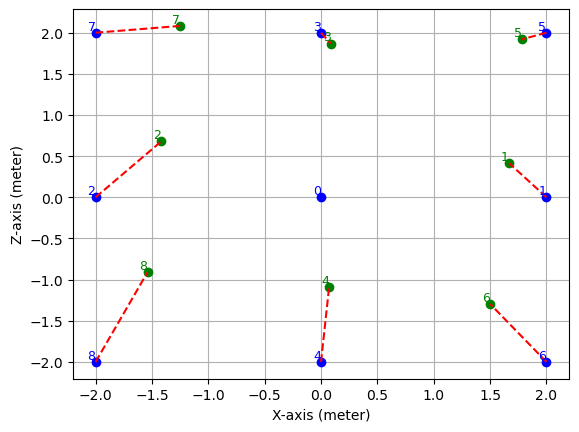

In [ ]:
scene = set2 #2
threshold=3.5
corrected_data=[]
for i in scene[1:]:
    known_image_dict, known_image_path_og = getImageFromIndex(scene[0],folder_path)
    unknown_image_dict, unknown_image_path_og = getImageFromIndex(i,folder_path)


    known_image = Image.open(known_image_path_og)
    known_image = known_image.rotate(-90, expand=True)
    known_image_size = known_image.size  #original size of image
    #known_image = known_image.resize((512, 512))

    unknown_image = Image.open(unknown_image_path_og)
    unknown_image = unknown_image.rotate(-90, expand=True)

    #master_size = [384, 512] #size of images according to master? recovered from load_images in getMast3rOutput
    #Fixme: I need to make this dynamic
    
    
    known_image_path = '/home/bjangley/VPR/mast3r/sanity_check/known.png'
    unknown_image_path = '/home/bjangley/VPR/mast3r/sanity_check/unknown.png'

    known_image.save(known_image_path, format='PNG')
    unknown_image.save(unknown_image_path, format='PNG')


    # K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243)
    # K_scaled = scale_intrinsics(K,known_image_size[1], known_image_size[0],master_size[0],master_size[1])

    K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) 
    K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[1],master_size[0])


    
    # Example usage
    matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(known_image_path, unknown_image_path,  threshold,visualizeMatches=False)
    
    # Predicted Transform copied from visloc.py
    ret_val, transformation = run_pnp(matches_im1.astype(np.float32), pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :], K_scaled.astype(np.float32))



    if ret_val: 
        print("Predicted Transform:\n", transformation)
        pnp_rotation = transformation[:3, :3]  # Replace with your PnP rotation
        pnp_translation = transformation[:3, 3]  # Replace with your PnP translation (in meters)
        
        # Calculate and print the magnitude of the translation
        translation_magnitude = np.linalg.norm(pnp_translation)
        print("Translation Magnitude:", translation_magnitude)
        corrected_data.append(pnp_translation)

scene_locations = scene_locations3
# Create a new figure
plt.figure()

# Plot and label scene_locations2 points
for i, location in enumerate(scene_locations):
    plt.plot(location[0]/100, location[1]/100, 'o', color='Blue')
    plt.text(location[0]/100, location[1]/100, str(i), color='Blue', fontsize=9, 
             ha='right', va='bottom')

# Plot and label corrected_data points
for i, location in enumerate(corrected_data):
    plt.plot(location[0], location[2], 'o', color='green')
    plt.text(location[0], location[2], str(i+1), color='green', fontsize=9, 
             ha='right', va='bottom')



# Draw lines between corresponding points
for i in range(len(corrected_data)):
    plt.plot([scene_locations[i+1][0]/100, corrected_data[i][0]],
             [scene_locations[i+1][1]/100, corrected_data[i][2]], 'r--')

# Add labels, title, and legend
plt.xlabel('X-axis (meter)')
plt.ylabel('Z-axis (meter)')


# Show the plot
plt.grid(True)
plt.show()


>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 3024x4032 --> 384x512
 (Found 2 images)
Images shape:  [[512 384]]
Mast3r Inference Time: 0.2297 seconds.
Point Matches Time: 0.1756 seconds.
Number of matches after conf mask:  318
(318, 3) shape
Predicted Transform:
 [[ 0.99984934 -0.00426806  0.01682515 -1.40632039]
 [ 0.0036767   0.99937975  0.0350228   0.31989373]
 [-0.0169642  -0.03495566  0.99924487  0.51638659]
 [ 0.          0.          0.          1.        ]]
Translation Magnitude: 1.531902133571512
>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 3024x4032 --> 384x512
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 3024x4032 --> 384x512
 (Found 2 images)
Images shape:  [[512 384]]
Mast3r Inference Time: 0.2067 seconds.
Point Matches Time: 0

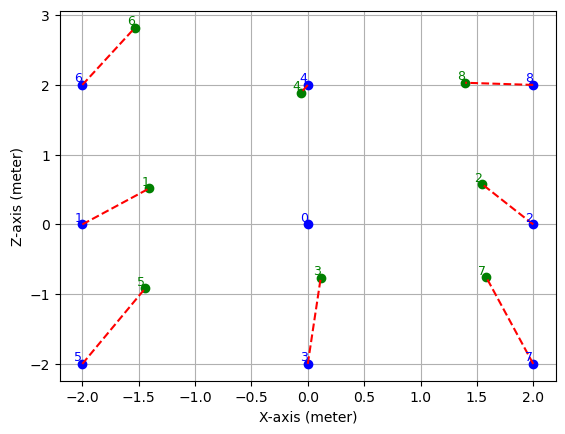

In [ ]:
scene = set3 
threshold=4
corrected_data=[]
for i in scene[1:]:
    known_image_dict, known_image_path_og = getImageFromIndex(scene[0],folder_path)
    unknown_image_dict, unknown_image_path_og = getImageFromIndex(i,folder_path)


    known_image = Image.open(known_image_path_og)
    known_image = known_image.rotate(-90, expand=True)
    known_image_size = known_image.size  #original size of image
    #known_image = known_image.resize((512, 512))

    unknown_image = Image.open(unknown_image_path_og)
    unknown_image = unknown_image.rotate(-90, expand=True)

    #master_size = [384, 512] #size of images according to master? recovered from load_images in getMast3rOutput
    #Fixme: I need to make this dynamic
    
    
    known_image_path = '/home/bjangley/VPR/mast3r/sanity_check/known.png'
    unknown_image_path = '/home/bjangley/VPR/mast3r/sanity_check/unknown.png'

    known_image.save(known_image_path, format='PNG')
    unknown_image.save(unknown_image_path, format='PNG')


    # K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243)
    # K_scaled = scale_intrinsics(K,known_image_size[1], known_image_size[0],master_size[0],master_size[1])

    K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) 
    K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[1],master_size[0])


    
    # Example usage
    matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(known_image_path, unknown_image_path,threshold=3.5, visualizeMatches=False)
    
    # Predicted Transform copied from visloc.py
    ret_val, transformation = run_pnp(matches_im1.astype(np.float32), pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :], K_scaled.astype(np.float32))



    if ret_val: 
        print("Predicted Transform:\n", transformation)
        pnp_rotation = transformation[:3, :3]  # Replace with your PnP rotation
        pnp_translation = transformation[:3, 3]  # Replace with your PnP translation (in meters)
        
        # Calculate and print the magnitude of the translation
        translation_magnitude = np.linalg.norm(pnp_translation)
        print("Translation Magnitude:", translation_magnitude)
        corrected_data.append(pnp_translation)

scene_locations = scene_locations4
# Create a new figure
plt.figure()

# Plot and label scene_locations2 points
for i, location in enumerate(scene_locations):
    plt.plot(location[0]/100, location[1]/100, 'o', color='Blue')
    plt.text(location[0]/100, location[1]/100, str(i), color='Blue', fontsize=9, 
             ha='right', va='bottom')

# Plot and label corrected_data points
for i, location in enumerate(corrected_data):
    plt.plot(location[0], location[2], 'o', color='green')
    plt.text(location[0], location[2], str(i+1), color='green', fontsize=9, 
             ha='right', va='bottom')



# Draw lines between corresponding points
for i in range(len(corrected_data)):
    plt.plot([scene_locations[i+1][0]/100, corrected_data[i][0]],
             [scene_locations[i+1][1]/100, corrected_data[i][2]], 'r--')

# Add labels, title, and legend
plt.xlabel('X-axis (meter)')
plt.ylabel('Z-axis (meter)')


# Show the plot
plt.grid(True)
plt.show()


>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Images shape:  [[384 512]]
Mast3r Inference Time: 0.2091 seconds.
Point Matches Time: 0.1086 seconds.
Number of matches after conf mask:  1268
(1268, 3) shape
Predicted Transform:
 [[ 0.99893302 -0.01821273 -0.04243953  0.01542527]
 [ 0.0172134   0.99956866 -0.02379472 -0.05993499]
 [ 0.04285459  0.02303881  0.99881565 -0.26192551]
 [ 0.          0.          0.          1.        ]]
Translation Magnitude: 0.26913772101988875
>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Images shape:  [[384 512]]
Mast3r Inference Time: 0.2076 seconds.
Point Matches Tim

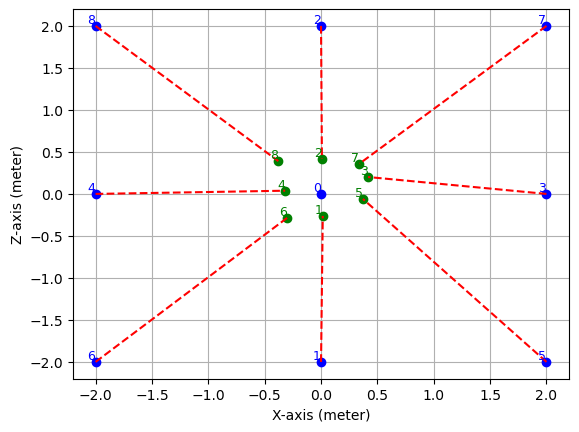

In [ ]:
scene = set4
threshold=6
corrected_data=[]
for i in scene[1:]:
    known_image_dict, known_image_path_og = getImageFromIndex(scene[0],folder_path)
    unknown_image_dict, unknown_image_path_og = getImageFromIndex(i,folder_path)


    known_image = Image.open(known_image_path_og)
    known_image_size = known_image.size  #original size of image
    #known_image = known_image.resize((512, 512))

    unknown_image = Image.open(unknown_image_path_og)
    # unknown_image = unknown_image.rotate(-90, expand=True)

    #master_size = [384, 512] #size of images according to master? recovered from load_images in getMast3rOutput
    #Fixme: I need to make this dynamic
    
    
    known_image_path = '/home/bjangley/VPR/mast3r/sanity_check/known.png'
    unknown_image_path = '/home/bjangley/VPR/mast3r/sanity_check/unknown.png'

    known_image.save(known_image_path, format='PNG')
    unknown_image.save(unknown_image_path, format='PNG')


    K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243)
    K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[0],master_size[1])

    # K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) 
    # K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[1],master_size[0])


    
    # Example usage
    matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(known_image_path, unknown_image_path,threshold, visualizeMatches=False)
    
    # Predicted Transform copied from visloc.py
    ret_val, transformation = run_pnp(matches_im1.astype(np.float32), pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :], K_scaled.astype(np.float32))



    if ret_val: 
        print("Predicted Transform:\n", transformation)
        pnp_rotation = transformation[:3, :3]  # Replace with your PnP rotation
        pnp_translation = transformation[:3, 3]  # Replace with your PnP translation (in meters)
        
        # Calculate and print the magnitude of the translation
        translation_magnitude = np.linalg.norm(pnp_translation)
        print("Translation Magnitude:", translation_magnitude)
        corrected_data.append(pnp_translation)

scene_locations = scene_locations2
# Create a new figure
plt.figure()

# Plot and label scene_locations2 points
for i, location in enumerate(scene_locations):
    plt.plot(location[0]/100, location[1]/100, 'o', color='Blue')
    plt.text(location[0]/100, location[1]/100, str(i), color='Blue', fontsize=9, 
             ha='right', va='bottom')

# Plot and label corrected_data points
for i, location in enumerate(corrected_data):
    plt.plot(location[0], location[2], 'o', color='green')
    plt.text(location[0], location[2], str(i+1), color='green', fontsize=9, 
             ha='right', va='bottom')



# Draw lines between corresponding points
for i in range(len(corrected_data)):
    plt.plot([scene_locations[i+1][0]/100, corrected_data[i][0]],
             [scene_locations[i+1][1]/100, corrected_data[i][2]], 'r--')

# Add labels, title, and legend
plt.xlabel('X-axis (meter)')
plt.ylabel('Z-axis (meter)')


# Show the plot
plt.grid(True)
plt.show()


>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Images shape:  [[384 512]]
Mast3r Inference Time: 0.2059 seconds.
Point Matches Time: 0.1350 seconds.
Number of matches after conf mask:  256
(256, 3) shape
Predicted Transform:
 [[ 0.9912737  -0.01773268 -0.13062163  0.84227321]
 [ 0.01077435  0.99849434 -0.05378628  0.02129786]
 [ 0.13137874  0.05190956  0.98997223  0.35115987]
 [ 0.          0.          0.          1.        ]]
Translation Magnitude: 0.9127929692433666
>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Images shape:  [[384 512]]
Mast3r Inference Time: 0.2072 seconds.
Point Matches Time: 

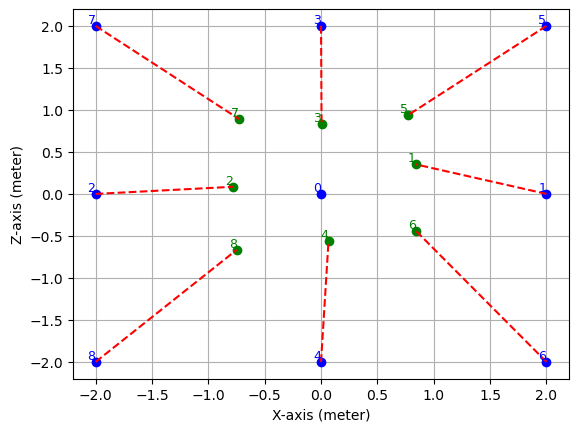

In [ ]:
scene = set5
threshold=3
corrected_data=[]
for i in scene[1:]:
    known_image_dict, known_image_path_og = getImageFromIndex(scene[0],folder_path)
    unknown_image_dict, unknown_image_path_og = getImageFromIndex(i,folder_path)


    known_image = Image.open(known_image_path_og)
    known_image_size = known_image.size  #original size of image
    #known_image = known_image.resize((512, 512))

    unknown_image = Image.open(unknown_image_path_og)
    # unknown_image = unknown_image.rotate(-90, expand=True)

    #master_size = [384, 512] #size of images according to master? recovered from load_images in getMast3rOutput
    #Fixme: I need to make this dynamic
    
    
    known_image_path = '/home/bjangley/VPR/mast3r/sanity_check/known.png'
    unknown_image_path = '/home/bjangley/VPR/mast3r/sanity_check/unknown.png'

    known_image.save(known_image_path, format='PNG')
    unknown_image.save(unknown_image_path, format='PNG')


    K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243)
    K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[0],master_size[1])

    # K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) 
    # K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[1],master_size[0])


    
    # Example usage
    matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(known_image_path, unknown_image_path,threshold=7, visualizeMatches=False)
    
    # Predicted Transform copied from visloc.py
    ret_val, transformation = run_pnp(matches_im1.astype(np.float32), pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :], K_scaled.astype(np.float32))



    if ret_val: 
        print("Predicted Transform:\n", transformation)
        pnp_rotation = transformation[:3, :3]  # Replace with your PnP rotation
        pnp_translation = transformation[:3, 3]  # Replace with your PnP translation (in meters)
        
        # Calculate and print the magnitude of the translation
        translation_magnitude = np.linalg.norm(pnp_translation)
        print("Translation Magnitude:", translation_magnitude)
        corrected_data.append(pnp_translation)

scene_locations = scene_locations3
# Create a new figure
plt.figure()

# Plot and label scene_locations2 points
for i, location in enumerate(scene_locations):
    plt.plot(location[0]/100, location[1]/100, 'o', color='Blue')
    plt.text(location[0]/100, location[1]/100, str(i), color='Blue', fontsize=9, 
             ha='right', va='bottom')

# Plot and label corrected_data points
for i, location in enumerate(corrected_data):
    plt.plot(location[0], location[2], 'o', color='green')
    plt.text(location[0], location[2], str(i+1), color='green', fontsize=9, 
             ha='right', va='bottom')



# Draw lines between corresponding points
for i in range(len(corrected_data)):
    plt.plot([scene_locations[i+1][0]/100, corrected_data[i][0]],
             [scene_locations[i+1][1]/100, corrected_data[i][2]], 'r--')

# Add labels, title, and legend
plt.xlabel('X-axis (meter)')
plt.ylabel('Z-axis (meter)')


# Show the plot
plt.grid(True)
plt.show()


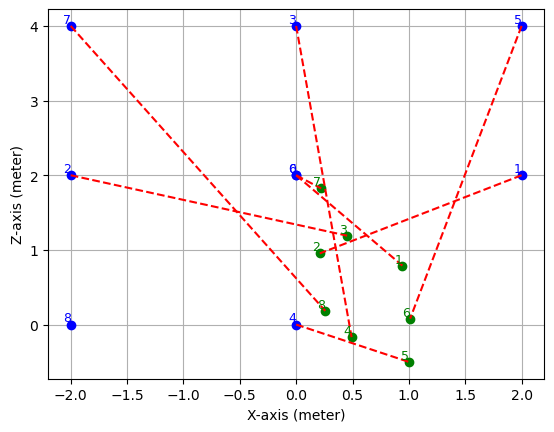

In [ ]:

scene_locations = scene_locations5
# Create a new figure
plt.figure()

# Plot and label scene_locations2 points
for i, location in enumerate(scene_locations):
    plt.plot(location[0]/100, location[1]/100, 'o', color='Blue')
    plt.text(location[0]/100, location[1]/100, str(i), color='Blue', fontsize=9, 
             ha='right', va='bottom')

# Plot and label corrected_data points
for i, location in enumerate(corrected_data):
    plt.plot(location[0], location[2], 'o', color='green')
    plt.text(location[0], location[2], str(i+1), color='green', fontsize=9, 
             ha='right', va='bottom')



# Draw lines between corresponding points
for i in range(len(corrected_data)):
    plt.plot([scene_locations[i][0]/100, corrected_data[i][0]],
             [scene_locations[i][1]/100, corrected_data[i][2]], 'r--')

# Add labels, title, and legend
plt.xlabel('X-axis (meter)')
plt.ylabel('Z-axis (meter)')


# Show the plot
plt.grid(True)
plt.show()

In [ ]:
print(known_image_size)
print(master_size)

(4032, 3024)
[512, 384]


>> Loading a list of 2 images
 - adding /home/bjangley/VPR/mast3r/sanity_check/known.png with resolution 4032x3024 --> 512x384
 - adding /home/bjangley/VPR/mast3r/sanity_check/unknown.png with resolution 4032x3024 --> 512x384
 (Found 2 images)
Images shape:  [[384 512]]
Mast3r Inference Time: 0.4350 seconds.
Point Matches Time: 0.2464 seconds.


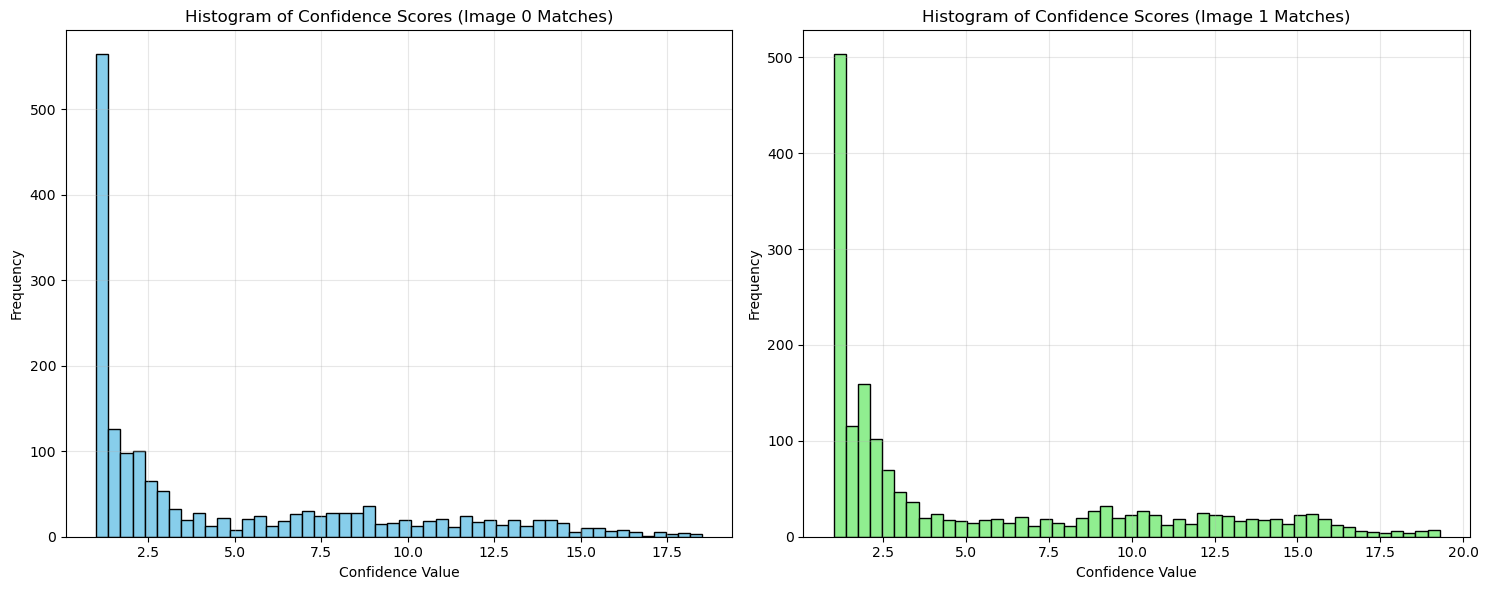

Number of matches:  1742


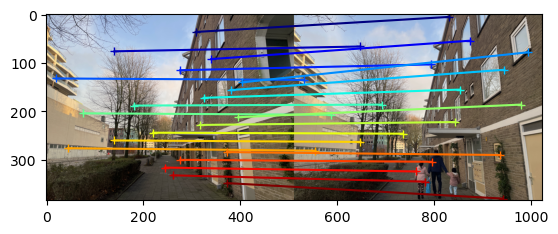

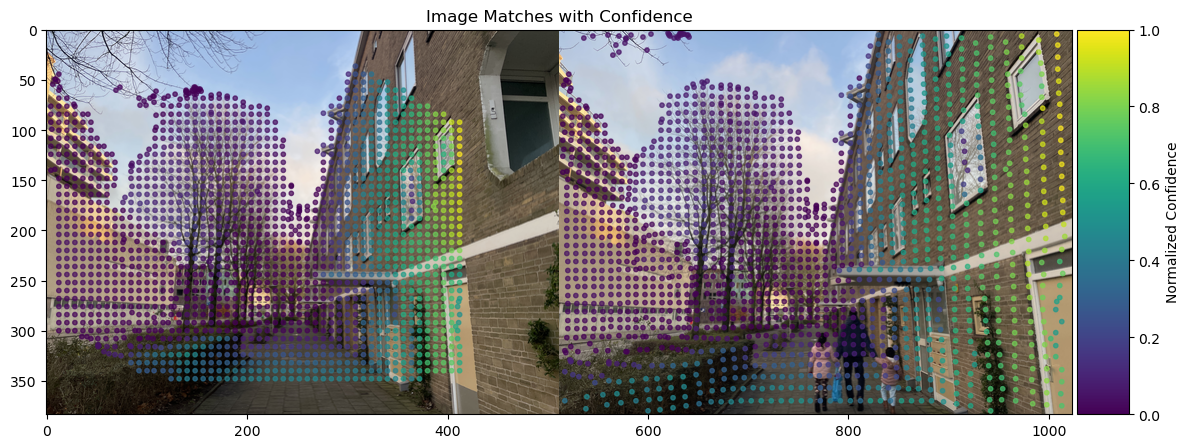

Number of matches after conf mask:  420
(420, 3) shape
Predicted Transform:
 [[ 0.97671458 -0.06737183 -0.2036901   0.00132517]
 [ 0.09890355  0.98390596  0.14881916  0.08257652]
 [ 0.19038569 -0.16549951  0.96765862  0.57679336]
 [ 0.          0.          0.          1.        ]]
Translation Magnitude: 0.5826759161554316


In [13]:
images_to_correct = [set5]
threshold = 8
new_location=[]
for row in images_to_correct:
    known_image_dict, known_image_path_og = getImageFromIndex(set5[0],folder_path)
    unknown_image_dict, unknown_image_path_og = getImageFromIndex(set5[3],folder_path)


    known_image = Image.open(known_image_path_og)
    # known_image = known_image.rotate(-90, expand=True)
    known_image_size = known_image.size  #original size of image


    unknown_image = Image.open(unknown_image_path_og)
    # unknown_image = unknown_image.rotate(-90, expand=True)    
    
    known_image_path = '/home/bjangley/VPR/mast3r/sanity_check/known.png'
    unknown_image_path = '/home/bjangley/VPR/mast3r/sanity_check/unknown.png'

    known_image.save(known_image_path, format='PNG')
    unknown_image.save(unknown_image_path, format='PNG')

    #K = CameraMatrix(2912.65,2909.73,2016,1512) #iphone12 estimated (wide)

    # K = CameraMatrix(2744.8442,2744.8442, 2014.26, 1521.5243)
    # K_scaled = scale_intrinsics(K,known_image_size[0], known_image_size[1],master_size[0],master_size[1])
    

    K = CameraMatrix(2744.8442,2744.8442, 1521.5243,2014.26) 
    K_scaled = scale_intrinsics(K,known_image_size[1], known_image_size[0],master_size[1],master_size[0])

    # Example usage
    matches_im0, matches_im1, pts3d_im0, pts3d_im1, conf_im0, conf_im1, desc_conf_im0, desc_conf_im1 = getMasterOutout(known_image_path, unknown_image_path, threshold,visualizeMatches=True)
    
    # Predicted Transform copied from visloc.py
    ret_val, transformation = run_pnp(matches_im1.astype(np.float32), pts3d_im0[matches_im0[:, 1], matches_im0[:, 0], :], K_scaled.astype(np.float32))



    if ret_val: 
        print("Predicted Transform:\n", transformation)
        pnp_rotation = transformation[:3, :3]  
        pnp_translation = transformation[:3, 3]  
        
        # Calculate and print the magnitude of the translation
        translation_magnitude = np.linalg.norm(pnp_translation)
        print("Translation Magnitude:", translation_magnitude)

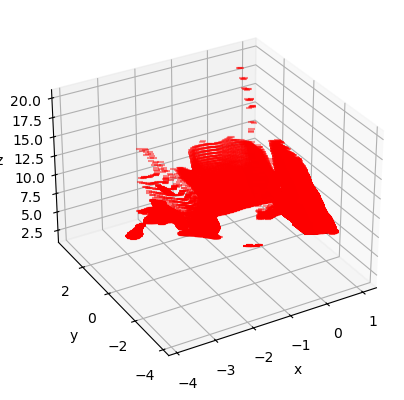

In [47]:
Ct = 3
X = pts3d_im1[conf_im1 > Ct]
C = conf_im1[conf_im1 > Ct]

ax = plt.figure().add_subplot(projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=C, marker=1)
ax.grid('on')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=-120, roll=0)

In [ ]:
    # def get_second_most_frequent(conf):
    #     unique, counts = np.unique(conf, return_counts=True)
    #     sorted_indices = np.argsort(-counts)
    #     return unique[sorted_indices[1]] if len(unique) > 1 else unique[0]
    
    # # Get thresholds for each image
    # threshold_im0 = get_second_most_frequent(match_conf_im0)
    # threshold_im1 = get_second_most_frequent(match_conf_im1)

    # print("Threshold (anchor and query): ", threshold_im0, threshold_im1)

    # # Apply thresholds to filter matches
    # conf_mask_im0 = match_conf_im0 > threshold_im0
    # conf_mask_im1 = match_conf_im1 > threshold_im1
    # conf_mask = conf_mask_im0 & conf_mask_im1

    # # Apply the mask to filter matches
    # matches_im0 = matches_im0[conf_mask]
    # matches_im1 = matches_im1[conf_mask]
        

    # def get_second_highest_peak(data):
    #     hist, bin_edges = np.histogram(data, bins=50)
    #     sorted_indices = np.argsort(hist)
    #     second_highest_bin = sorted_indices[-2]
    #     return bin_edges[second_highest_bin]
    
    # threshold_im0 = get_second_highest_peak(conf_im0[matches_im0[:, 1], matches_im0[:, 0]])
    # threshold_im1 = get_second_highest_peak(conf_im1[matches_im1[:, 1], matches_im1[:, 0]])
    # print("Threshold (anchor and query): ", threshold_im0, threshold_im1)

    # conf_mask = (conf_im0[matches_im0[:, 1], matches_im0[:, 0]] >= threshold_im0) & \
    #         (conf_im1[matches_im1[:, 1], matches_im1[:, 0]] >= threshold_im1)

    # matches_im0 = matches_im0[conf_mask]
    # matches_im1 = matches_im1[conf_mask]
        
    # Sort matches by confidence scores
    # sorted_indices_im0 = np.argsort(match_conf_im0)[::-1]
    # sorted_indices_im1 = np.argsort(match_conf_im1)[::-1]

    # # Select top 200 matches or all matches if fewer than 200
    # top_matches_im0 = sorted_indices_im0[:min(300, len(sorted_indices_im0))]
    # top_matches_im1 = sorted_indices_im1[:min(300, len(sorted_indices_im1))]

    # # Create a mask for the union of top matches from both images
    # conf_mask = np.zeros(len(matches_im0), dtype=bool)
    # conf_mask[top_matches_im0] = True
    # conf_mask[top_matches_im1] = True

    # # Apply the mask to filter matches
    # matches_im0 = matches_im0[conf_mask]
    # matches_im1 = matches_im1[conf_mask]


    # threshold = 3.5
    # conf_mask = (conf_im0[matches_im0[:, 1], matches_im0[:, 0]] > threshold) & \
    #             (conf_im1[matches_im1[:, 1], matches_im1[:, 0]] > threshold)

    # matches_im0 = matches_im0[conf_mask]
    # matches_im1 = matches_im1[conf_mask]